In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from scipy.signal import savgol_filter
import pickle
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler

import IPython
import IPython.display

# Read in Processed Data

## Filtering / Normalisation

In [4]:
def filter_data(input_data):
    output = input_data.copy()
    filtered = savgol_filter(output['GlucoseLevel'], 7, 3)
    output['GlucoseLevel'] = filtered
    return output

In [5]:
compartmentals = ['Short', 'Long', 'Carb']
col_names= ['GlucoseLevel', 'Long', 'Short', 'Carb']
time_ranges = ['15', '30', '60']

In [6]:
def normalise_data(training_data, testing_data):
    testing = testing_data.copy()
    training = training_data.copy()
    scaler = MinMaxScaler()
    scaler.fit(training)
    training[col_names] = scaler.fit_transform(training)
    testing[col_names] = scaler.transform(testing)
    return training, testing, scaler

In [7]:
datapath = '../../OhioT1DM/data/processed/'
train_563 = pd.read_csv(datapath + 'train_563.csv').set_index('ts')
train_588 = pd.read_csv(datapath + 'train_588.csv').set_index('ts')
train_570 = pd.read_csv(datapath + 'train_570.csv').set_index('ts')

test_563 = pd.read_csv(datapath + 'test_563.csv').set_index('ts')
test_588 = pd.read_csv(datapath + 'test_588.csv').set_index('ts')
test_570 = pd.read_csv(datapath + 'test_570.csv').set_index('ts')

In [8]:
all_train_data = [train_563, train_588, train_570]
all_test_data = [test_563, test_588, test_570]
all_filtered_data = [filter_data(x) for x in all_train_data]
patient_names = {0: '563', 1: '588', 2: '570'}

In [9]:
def normalise_all_data(train_to_norm, test_to_norm):
    train_normed = []
    test_normed = []
    used_scalers = []
    for i in range(len(train_to_norm)):
        train = train_to_norm[i]
        test = test_to_norm[i]
        normed_tr, normed_te, scaler = normalise_data(train, test)
        train_normed.append(normed_tr)
        test_normed.append(normed_te)
        used_scalers.append(scaler)
    return train_normed, test_normed, used_scalers

        
all_train_normed, all_test_normed, scalers  = normalise_all_data(all_train_data, all_test_data)
all_train_filtnormed, all_test_filtnormed, filt_scalers = normalise_all_data(all_filtered_data, all_test_data)

[]

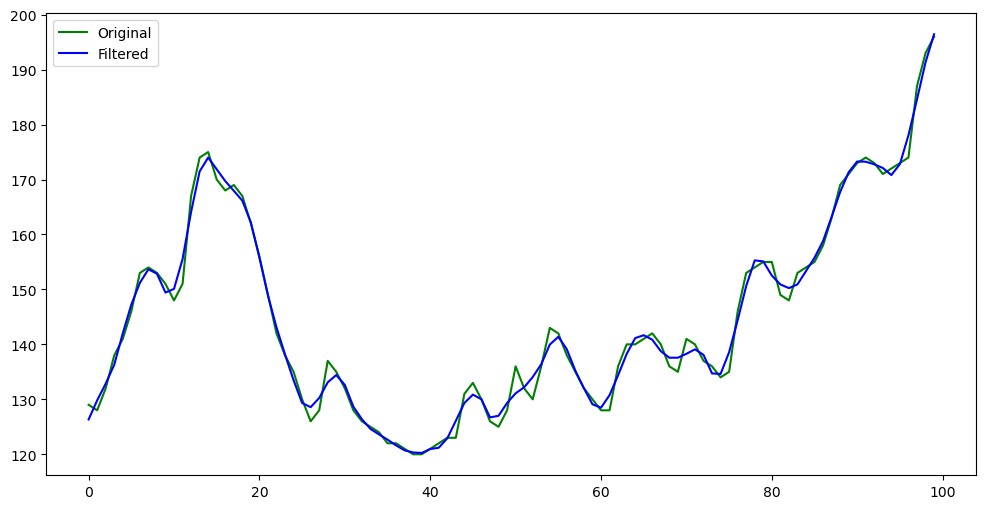

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(list(range(100)), all_train_data[0]['GlucoseLevel'][100:200], c='g', label='Original')
plt.plot(list(range(100)), all_filtered_data[0]['GlucoseLevel'][100:200], c='b', label='Filtered')
plt.legend()
plt.plot()

[]

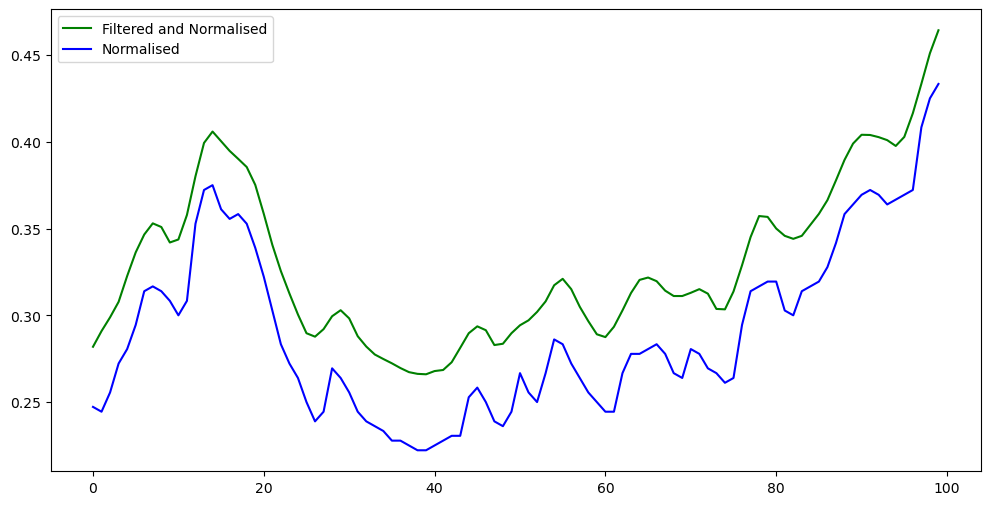

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(list(range(100)), all_train_filtnormed[0]['GlucoseLevel'][100:200], c='g', label='Filtered and Normalised')
plt.plot(list(range(100)), all_train_normed[0]['GlucoseLevel'][100:200], c='b', label='Normalised')
plt.legend()
plt.plot()

In [12]:
all_train_data[0].describe()

,GlucoseLevel,Long,Short,Carb
count,12124.00000,12124.000000,12124.000000,12124.000000
mean,146.07712,0.830823,12.535700,6.399876
std,49.68904,0.250614,9.056443,26.727100
min,40.00000,0.000000,0.000000,0.000000
25%,108.00000,0.700000,6.450000,0.000000
50%,140.00000,0.800000,11.035417,0.000000
75%,177.00000,0.800000,17.000434,1.700000
max,400.00000,1.600000,74.305208,378.750000


In [13]:
all_train_normed[0].describe()

,GlucoseLevel,Long,Short,Carb
count,12124.000000,12124.000000,12124.000000,12124.000000
mean,0.294659,0.519264,0.168706,0.016897
std,0.138025,0.156633,0.121882,0.070567
min,0.000000,0.000000,0.000000,0.000000
25%,0.188889,0.437500,0.086804,0.000000
50%,0.277778,0.500000,0.148515,0.000000
75%,0.380556,0.500000,0.228792,0.004488
max,1.000000,1.000000,1.000000,1.000000


# Setup Window Slicing Code

In [14]:
class PredictionRangeGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df, test_df, label_columns=None, batch_size=32):
        
        self.batch_size = batch_size
        
        # Store data in Generator
        self.train_df = train_df
        self.test_df = test_df
        
        #Work out column indices for different labels
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name : i for i, name in 
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # Work out window params
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:,:, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
        
            
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
            
        return inputs, labels
    
    def plot(self, model=None, plot_col='GlucoseLevel', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 2*max_subplots))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10, c='#00008B')

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        label='Actual', c='#90EE90', edgecolors='k', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          label='Predicted',
                          marker='X', c='#808080', edgecolors='k', s=64)

            if n == 0:
                plt.legend()

            plt.xlabel('Time [index]')
        
        
    def make_dataset(self, data, shuffle):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=self.batch_size,)
        
        ds = ds.map(self.split_window)
        
        return ds
        
    @property
    def train(self):
        return self.make_dataset(self.train_df, True)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df, False)
    
    @property
    def example(self):
        """Get and cache an example batch for plotting"""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch found, so get one from train df
            result = next(iter(self.train))
            self._example = result
        return result

# Setup a Baseline to Test Prediction Against

In [15]:
class LinearBaseline(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
    def call(self, inputs):
        """
        Simply returns last value as next value
        """
        return inputs[:, -1, tf.newaxis]

In [17]:
linear_base = LinearBaseline()
linear_base.compile(loss=tf.keras.losses.MeanSquaredError(),
                   metrics=[tf.keras.metrics.RootMeanSquaredError()],)

# Setup Windows to be Predicted Over

In [18]:
PREV = 4

In [19]:
fifteen_range_g = PredictionRangeGenerator(
    input_width = PREV,
    label_width = 1,
    shift = 3,
    label_columns=['GlucoseLevel'],
    train_df=pd.DataFrame(all_train_data[2]['GlucoseLevel']),
    test_df=pd.DataFrame(all_test_data[2]['GlucoseLevel'])
)

thirty_range_g = PredictionRangeGenerator(
    input_width = PREV,
    label_width = 1,
    shift = 6,
    label_columns=['GlucoseLevel'],
    train_df=pd.DataFrame(all_train_data[2]['GlucoseLevel']),
    test_df=pd.DataFrame(all_test_data[2]['GlucoseLevel'])
)

sixty_range_g = PredictionRangeGenerator(
    input_width = PREV,
    label_width = 1,
    shift = 12,
    label_columns=['GlucoseLevel'],
    train_df=pd.DataFrame(all_train_data[2]['GlucoseLevel']),
    test_df=pd.DataFrame(all_test_data[2]['GlucoseLevel'])
)

def create_range(shift, train, test, prev=PREV):
    return PredictionRangeGenerator(
        input_width = PREV,
        label_width = 1,
        shift = shift,
        label_columns=['GlucoseLevel'],
        train_df=train,
        test_df=test
    )

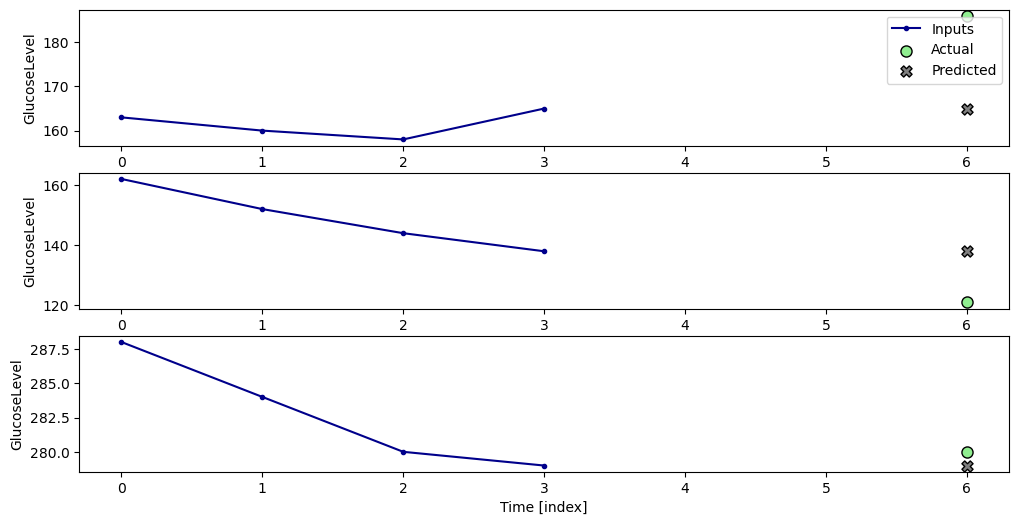

In [20]:
fifteen_range_g.plot(linear_base)

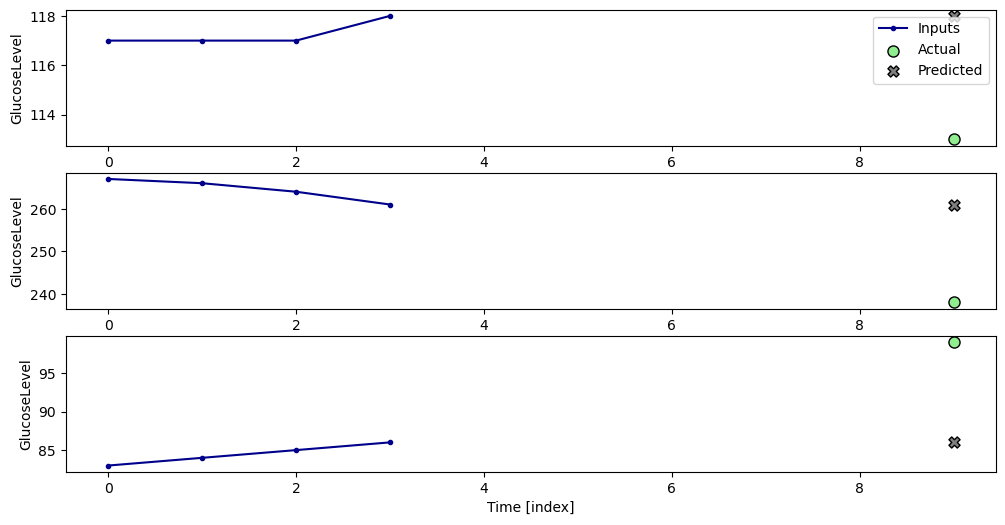

In [21]:
thirty_range_g.plot(linear_base)

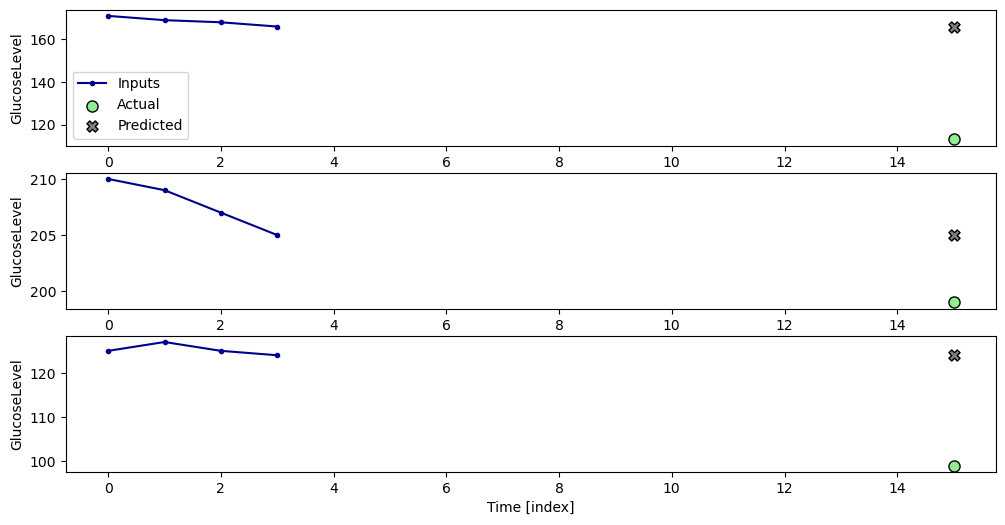

In [22]:
sixty_range_g.plot(linear_base)

# Setup Model Training Code

In [23]:
def get_scaled_glucose(scaler, val):
    scaled = (val - tf.constant(scaler.min_[0], dtype='float32')) / tf.constant(scaler.scale_[0], dtype='float32')
    return scaled

def inverse_glucose(scaler, glucose):
    temp = pd.DataFrame(np.zeros((len(glucose), len(col_names))), columns=col_names)
    temp['GlucoseLevel'] = glucose
    temp = pd.DataFrame(scaler.inverse_transform(temp), columns=col_names)
    return temp['GlucoseLevel'].values

In [24]:
class Normalised_MSE(tf.keras.losses.Loss):
    def __init__(self, scaler):
        super().__init__()
        self.scaler = scaler
    def call(self, y_true, y_pred):
        scaled_t = get_scaled_glucose(self.scaler, y_true)
        scaled_p = get_scaled_glucose(self.scaler, y_pred)
        val = tf.math.reduce_mean(tf.math.square(scaled_t - scaled_p))
        return val

def Normalised_RMSE(scaler):
    def RMSE(y_true, y_pred):
        scaled_t = get_scaled_glucose(scaler, y_true)
        scaled_p = get_scaled_glucose(scaler, y_pred)
        val = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(scaled_t - scaled_p)))
        return val
    return RMSE

In [25]:
# Setup function to train model on training data

def fit_model(model, predict_range, lr=0.01, MAX_EPOCHS=20):
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError(),
                        tf.keras.metrics.MeanAbsoluteError()])

    model_history = model.fit(predict_range.train, epochs=MAX_EPOCHS)
    return model_history

In [26]:
def fit_normalised_model(model, predict_range, scaler, lr=0.01, MAX_EPOCHS=20):
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[Normalised_RMSE(scaler)])

    model_history = model.fit(predict_range.train, epochs=MAX_EPOCHS)
    return model_history

In [27]:
def plot_model_predictions(model, pred_range, num_graphs=3, normalised=False, scaler=None):
    all_inputs = np.concatenate([x for x,y  in pred_range.test], axis=0)
    all_labels = np.concatenate([y for x,y in pred_range.test], axis=0)
    size = len(all_inputs)
    graph_size = size // num_graphs
    index = 0
    for i in range(num_graphs):
        cur_slice = slice(index, index+graph_size)
        if i == (num_graphs - 1):
            cur_slice = slice(index, size)
        cur_inputs = all_inputs[cur_slice]
        cur_labels = all_labels[cur_slice][:,0]
        print(cur_labels.shape)
        index += graph_size
        predictions = model(cur_inputs)[:,0,tf.newaxis]
        predictions = predictions.numpy().reshape(-1)
        cur_labels = cur_labels.reshape(-1)
        if normalised:
            predictions = inverse_glucose(scaler, predictions)
            cur_labels = inverse_glucose(scaler, cur_labels)
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.plot(list(range(len(predictions))), predictions, 'g', linestyle='dashed', label='Predicted')
        plt.plot(list(range(len(cur_labels))), cur_labels, '-', label='Actual')
        plt.legend()
        plt.show()
    

In [36]:
def train_and_test_model(model, train, test, shift, previous=PREV, epochs=40):
    print("Running for Range: {} mins\n".format(shift*5))
    pred_range = create_range(shift, train, test, previous)
    fit_model(model, pred_range, lr=1e-3, MAX_EPOCHS=epochs)
    IPython.display.clear_output()
    train_acc = model.evaluate(pred_range.train)
    test_acc = model.evaluate(pred_range.test)
    print("Train Accuracy: {:.2f}, Test Accuracy: {:.2f}\n".format(train_acc[1], test_acc[1]))
    return train_acc[1], test_acc[1], model

def train_and_test_normed_model(model, train, test, shift, scaler, previous=PREV, epochs=40):
    print("Running for Range: {} mins\n".format(shift*5))
    pred_range = create_range(shift, train, test, previous)
    fit_normalised_model(model, pred_range, scaler, lr=1e-3, MAX_EPOCHS=epochs)
    IPython.display.clear_output()
    train_acc = model.evaluate(pred_range.train)
    test_acc = model.evaluate(pred_range.test)
    print("Train Accuracy: {:.2f}, Test Accuracy: {:.2f}\n".format(train_acc[1], test_acc[1]))
    return train_acc[1], test_acc[1], model

In [63]:
def save_result(result, path):
    f = open(path, "wb")
    pickle.dump(result, f)
    f.close()

def save_all_models(model_dict, prefix):
    for key in model_dict:
        for k, model in enumerate(model_dict[key]):
            save_string = "models/{}/{}".format(key, prefix+time_ranges[k])
            model.save(save_string)
        
    
def glucose_input_only(input_data):
    return pd.DataFrame(input_data['GlucoseLevel'])

def no_bolus(input_data):
    return pd.DataFrame(input_data[['GlucoseLevel', 'Short', 'Carb']])
    
def add_to_dict(dictionary, key, value):
    if key in dictionary:
        dictionary[key].append(value)
    else:
        dictionary[key] = [value]
    return dictionary

def run_experiment(training, testing, ranges, previous, epochs, create_model, filepath, prefix, glucose=False, num_out=1, num_units=288):
    accs = {}
    models = {}
    for i in range(len(training)):
        for j in range(len(ranges)):
            name = patient_names[i]
            print("Running for Patient {}\n".format(name))
            cur_train = glucose_input_only(training[i]) if glucose else training[i]
            cur_test = glucose_input_only(testing[i]) if glucose else testing[i]
            shift = ranges[j]
            prev = previous[j]
            epoch = epochs[j]
            train_acc, test_acc, model = train_and_test_model(create_model(num_out, num_units=num_units),
                                                      cur_train,
                                                      cur_test,
                                                      shift,
                                                      prev,
                                                      epoch)        
            accs = add_to_dict(accs, name, [train_acc, test_acc])
            models = add_to_dict(models, name, model)
        save_result(accs, filepath)
    save_all_models(models, prefix)
    return accs, models


def run_normed_experiment(training, testing, ranges, previous, epochs, create_model, filepath, prefix, scalers, glucose=False, num_out=1, num_units=288, no_bolus_input=False):
    accs = {}
    models = {}
    for i in range(len(training)):
        for j in range(len(ranges)):
            name = patient_names[i]
            print("Running for Patient {}\n".format(name))
            cur_train = no_bolus(training[i]) if no_bolus_input else training[i]
            cur_test = no_bolus(testing[i]) if no_bolus_input else testing[i]
            shift = ranges[j]
            prev = previous[j]
            epoch = epochs[j]
            scaler = scalers[j]
            train_acc, test_acc, model = train_and_test_normed_model(create_model(num_out, num_units=num_units),
                                                      cur_train,
                                                      cur_test,
                                                      shift,
                                                      scaler,
                                                      prev,
                                                      epoch)        
            accs = add_to_dict(accs, name, [train_acc, test_acc])
            models = add_to_dict(models, name, model)
        save_result(accs, filepath)
    save_all_models(models, prefix)
    return accs, models

# Experiment with Different models

In [55]:
class ChangeLayer(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def call(self, inputs, *args, **kwargs):
        change = self.model(inputs, *args, **kwargs)
        return inputs + change
        

In [56]:
def create_normal_lstm(output_length, num_units=128):
    return tf.keras.models.Sequential([
        tf.keras.layers.LSTM(num_units, return_sequences=False),
        tf.keras.layers.Dense(output_length),
    tf.keras.layers.Reshape([output_length, 1])
    ])

def create_change_lstm(output_length, num_units=128):
    return ChangeLayer(
        tf.keras.models.Sequential([
        tf.keras.layers.LSTM(num_units, return_sequences=False),
        tf.keras.layers.Dense(output_length),
        tf.keras.layers.Reshape([output_length, 1])
        ])
    )

def create_multilayer_lstm(output_length, num_units=128):
    return tf.keras.models.Sequential([
        tf.keras.layers.LSTM(num_units, return_sequences=True),
        tf.keras.layers.LSTM(num_units, return_sequences=False),
        tf.keras.layers.Dense(output_length),
    tf.keras.layers.Reshape([output_length, 1])
    ])

def create_bidirectional_lstm(output_length, num_units=128):
    forward_layer = tf.keras.layers.LSTM(num_units, return_sequences=False)
    backward_layer = tf.keras.layers.LSTM(num_units, return_sequences=False, go_backwards=True)
    return tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer),
        tf.keras.layers.Dense(output_length),
    tf.keras.layers.Reshape([output_length, 1])
    ])

In [57]:
lstm = create_normal_lstm(1, num_units = 288)

In [58]:
change_lstm = create_change_lstm(1, num_units=288)

In [59]:
print("Input shape: ", thirty_range_g.example[0].shape)
print('Output shape:', change_lstm(thirty_range_g.example[0]).shape)

Input shape:  (32, 4, 1)
Output shape: (32, 4, 1)


In [60]:
print("Input shape: ", fifteen_range_g.example[0].shape)
print('Output shape:', lstm(fifteen_range_g.example[0]).shape)

Input shape:  (32, 4, 1)
Output shape: (32, 1, 1)


In [61]:
ranges = [3,6,12]
previous = [PREV]*3
epochs = [30]*3

In [64]:
accs_norm, models_norm = run_normed_experiment(all_train_normed,
                                        all_test_normed,
                                        ranges, previous, epochs,
                                        create_normal_lstm,
                                        'results/normedNoBolus.pkl',
                                        'noBolus', scalers, glucose=False, no_bolus_input=True
                                              )

86/86 [==============================] - 1s 6ms/step - loss: 0.0073 - RMSE: 25.2407
Train Accuracy: 28.21, Test Accuracy: 25.24



INFO:tensorflow:Assets written to: models/563/noBolus15/assets


INFO:tensorflow:Assets written to: models/563/noBolus15/assets


INFO:tensorflow:Assets written to: models/563/noBolus30/assets


INFO:tensorflow:Assets written to: models/563/noBolus30/assets


INFO:tensorflow:Assets written to: models/563/noBolus60/assets


INFO:tensorflow:Assets written to: models/563/noBolus60/assets


INFO:tensorflow:Assets written to: models/588/noBolus15/assets


INFO:tensorflow:Assets written to: models/588/noBolus15/assets


INFO:tensorflow:Assets written to: models/588/noBolus30/assets


INFO:tensorflow:Assets written to: models/588/noBolus30/assets


INFO:tensorflow:Assets written to: models/588/noBolus60/assets


INFO:tensorflow:Assets written to: models/588/noBolus60/assets


INFO:tensorflow:Assets written to: models/570/noBolus15/assets


INFO:tensorflow:Assets written to: models/570/noBolus15/assets


INFO:tensorflow:Assets written to: models/570/noBolus30/assets


INFO:tensorflow:Assets written to: models/570/noBolus30/assets


INFO:tensorflow:Assets written to: models/570/noBolus60/assets


INFO:tensorflow:Assets written to: models/570/noBolus60/assets


## Tune hyperparams for unfiltered

In [38]:
def get_all_inputs_and_labels(pred_range):
    all_inputs = np.concatenate([x for x,y  in pred_range.train], axis=0)
    all_labels = np.concatenate([y for x,y in pred_range.train], axis=0)
    return all_inputs, all_labels
    
def build_lstm_model(hp):
    hp_units = hp.Int('lstm_units', min_value=32, max_value=512, step=64)
    
    hp_lr = hp.Choice('lr', values=[1e-2,1e-3,])
    
    model = create_normal_lstm(1, num_units=hp_units)
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model


In [39]:
tuner = kt.Hyperband(build_lstm_model, max_epochs=40, objective='loss', factor=3, directory='tuning', project_name='Testing', overwrite=True)

In [40]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [41]:
# tuner.search(sixty_range_g.train, epochs=40, callbacks=[stop_early])

In [42]:
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [67]:
lstm2 = create_normal_lstm(1, num_units=288)

In [57]:
pred3 = create_range(6, glucose_input_only(all_train_data[0]), glucose_input_only(all_test_data[0]), prev=6)

In [68]:
pred2 = create_range(6, no_bolus(all_train_normed[0]), no_bolus(all_test_normed[0]), prev=4)

In [59]:
lstm  = create_bidirectional_lstm(1, num_units=288)

In [60]:
pred = create_range(6, no_bolus(all_train_normed[2]), no_bolus(all_test_normed[2]), prev=6)

In [61]:
scaler = scalers[0]

In [62]:
scaler2 = filt_scalers[0]

In [63]:
print(scaler.min_)

[-0.11111111  0.          0.          0.        ]


In [64]:
print(scaler.scale_)

[0.00277778 0.625      0.01345801 0.00264026]


In [69]:
fit_normalised_model(lstm2, pred2, scaler, lr=1e-3, MAX_EPOCHS=30)

Epoch 1/30
379/379 [==============================] - 6s 12ms/step - loss: 0.0059 - RMSE: 26.0915
Epoch 2/30
379/379 [==============================] - 5s 12ms/step - loss: 0.0038 - RMSE: 21.8036
Epoch 3/30
379/379 [==============================] - 5s 12ms/step - loss: 0.0033 - RMSE: 20.0179
Epoch 4/30
379/379 [==============================] - 5s 13ms/step - loss: 0.0030 - RMSE: 19.2010
Epoch 5/30
379/379 [==============================] - 5s 12ms/step - loss: 0.0029 - RMSE: 18.7708
Epoch 6/30
379/379 [==============================] - 5s 14ms/step - loss: 0.0029 - RMSE: 18.6538
Epoch 7/30
379/379 [==============================] - 6s 15ms/step - loss: 0.0028 - RMSE: 18.3353
Epoch 8/30
379/379 [==============================] - 5s 14ms/step - loss: 0.0027 - RMSE: 18.1118
Epoch 9/30
379/379 [==============================] - 6s 15ms/step - loss: 0.0026 - RMSE: 17.8441
Epoch 10/30
379/379 [==============================] - 6s 15ms/step - loss: 0.0026 - RMSE: 17.8113
Epoch 11/30
379/379

In [72]:
lstm2.evaluate(pred2.test)

80/80 [==============================] - 0s 5ms/step - loss: 0.0029 - RMSE: 16.8003


[0.0028605277184396982, 16.800270080566406]

In [149]:
fit_normalised_model(lstm, pred, scaler, lr=1e-3, MAX_EPOCHS=30)

Epoch 1/30
379/379 [==============================] - 11s 22ms/step - loss: 0.0054 - RMSE: 24.9337
Epoch 2/30
379/379 [==============================] - 9s 23ms/step - loss: 0.0035 - RMSE: 20.7098
Epoch 3/30
379/379 [==============================] - 9s 22ms/step - loss: 0.0031 - RMSE: 19.5132
Epoch 4/30
379/379 [==============================] - 9s 23ms/step - loss: 0.0031 - RMSE: 19.5016
Epoch 5/30
379/379 [==============================] - 9s 23ms/step - loss: 0.0030 - RMSE: 19.2377
Epoch 6/30
379/379 [==============================] - 12s 33ms/step - loss: 0.0029 - RMSE: 18.7346
Epoch 7/30
379/379 [==============================] - 14s 38ms/step - loss: 0.0028 - RMSE: 18.4426
Epoch 8/30
379/379 [==============================] - 10s 25ms/step - loss: 0.0027 - RMSE: 18.1346
Epoch 9/30
379/379 [==============================] - 13s 33ms/step - loss: 0.0026 - RMSE: 17.9521
Epoch 10/30
379/379 [==============================] - 11s 28ms/step - loss: 0.0026 - RMSE: 17.8098
Epoch 11/30
3

In [71]:
lstm.evaluate(pred.test)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [132]:
linear_base.evaluate(pred3.test)

80/80 [==============================] - 0s 1ms/step - loss: 431.8566 - root_mean_squared_error: 20.7812


[431.8565979003906, 20.781160354614258]

(684, 1)


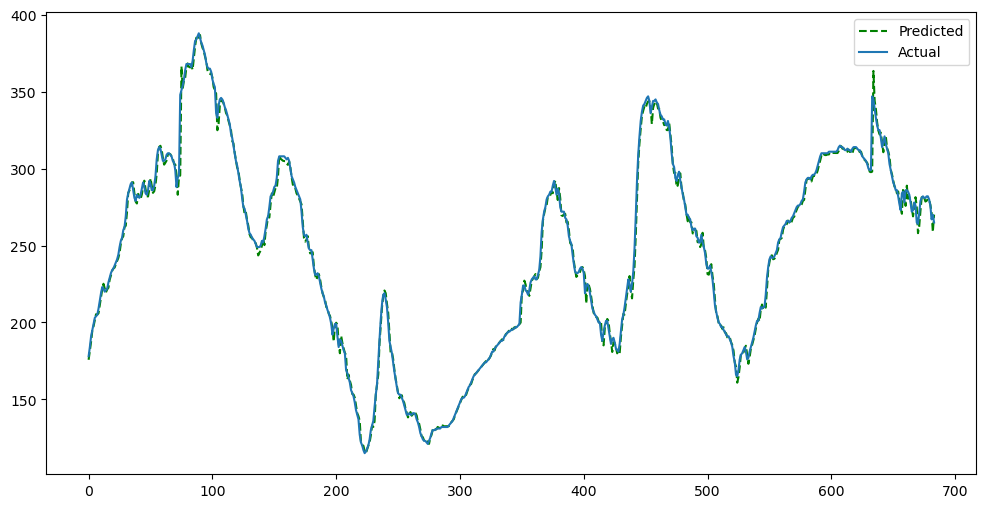

(684, 1)


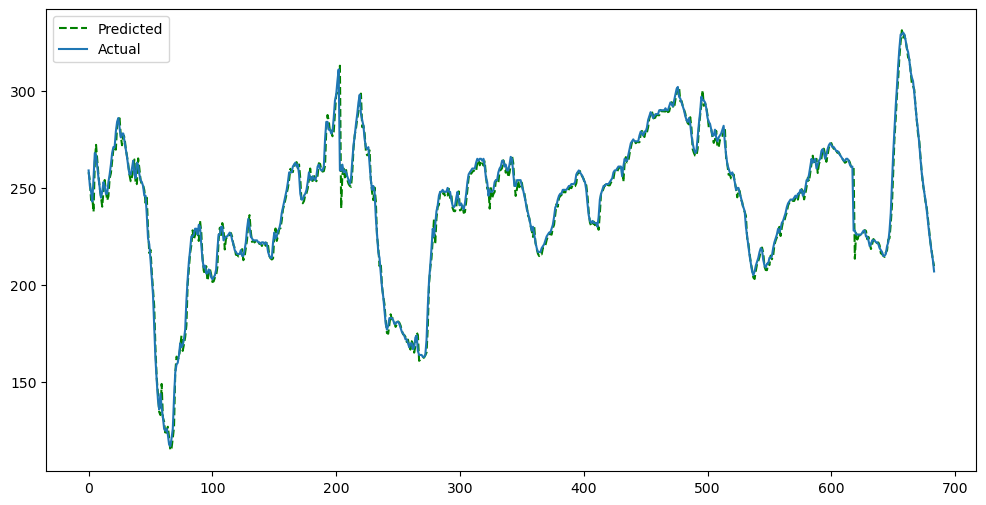

(684, 1)


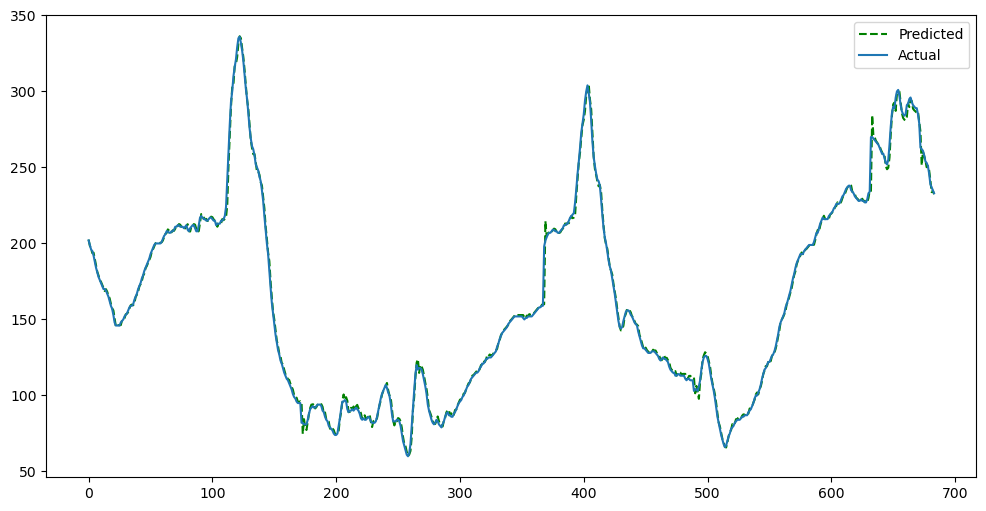

(687, 1)


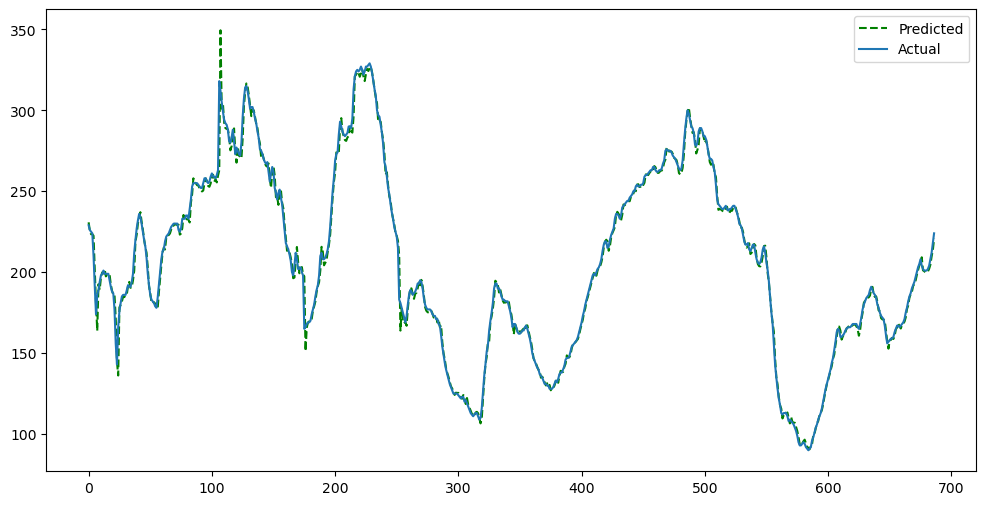

(136, 1)


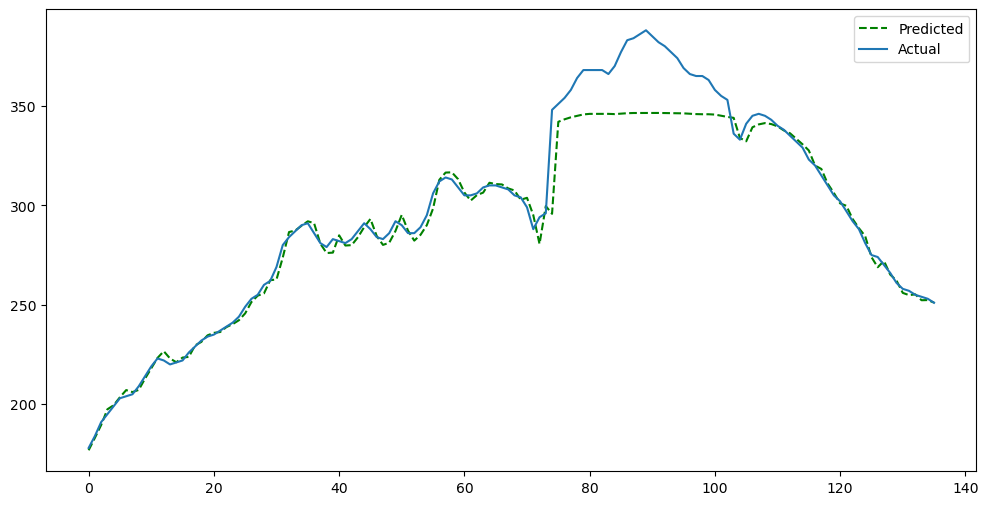

(136, 1)


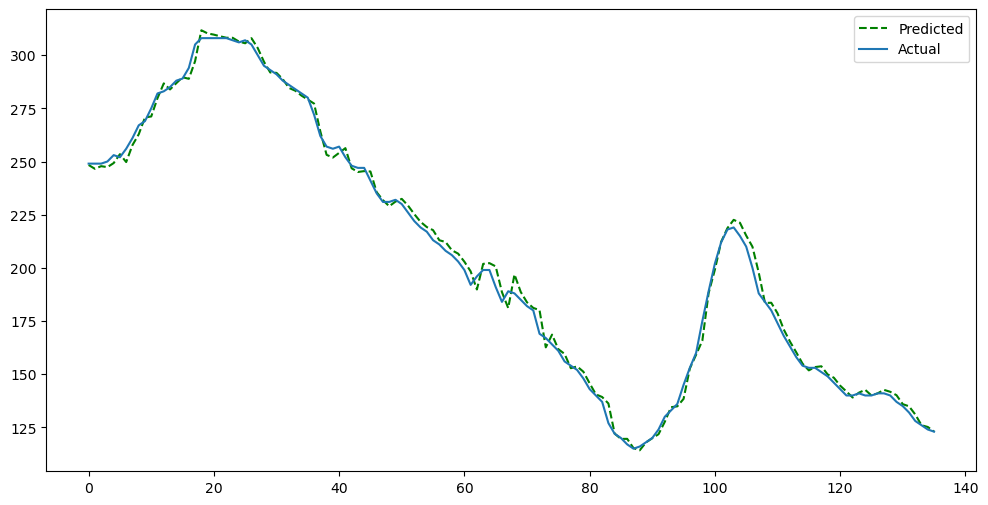

(136, 1)


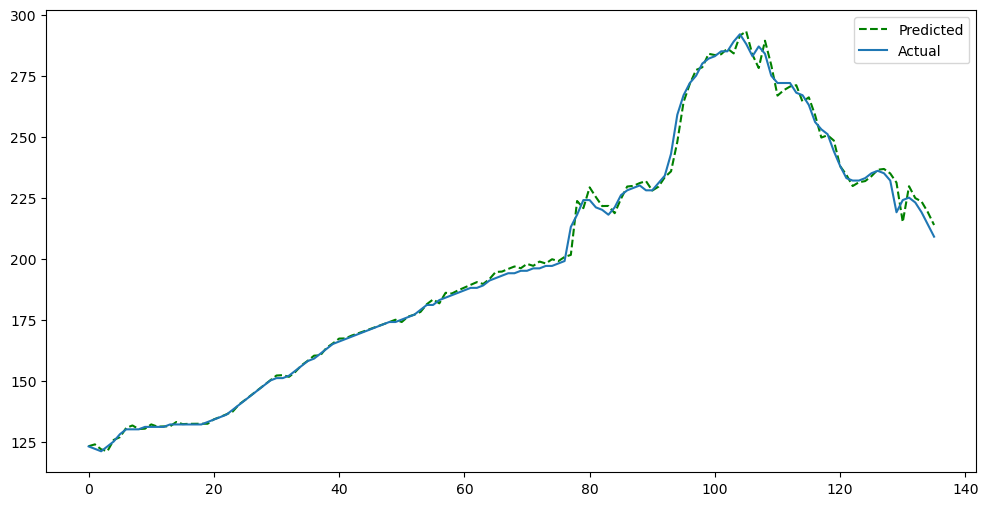

(136, 1)


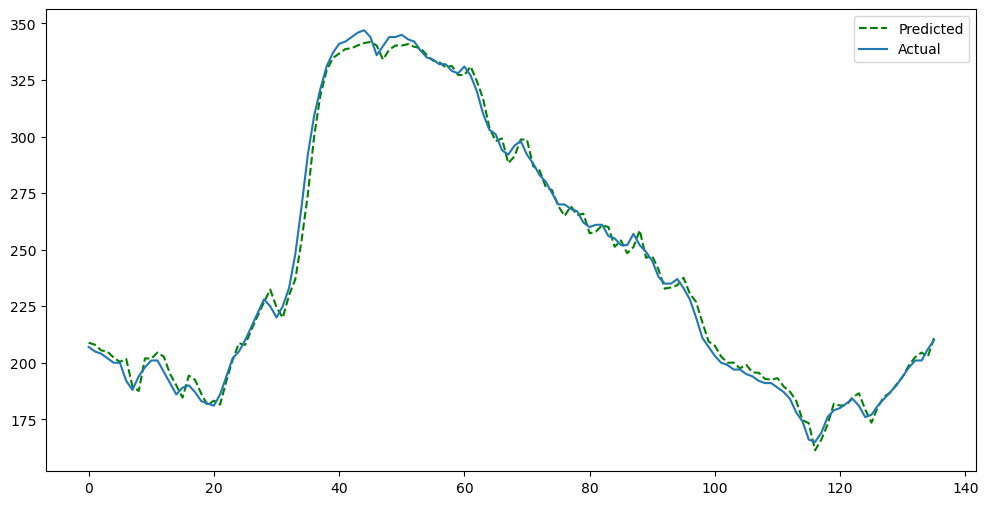

(136, 1)


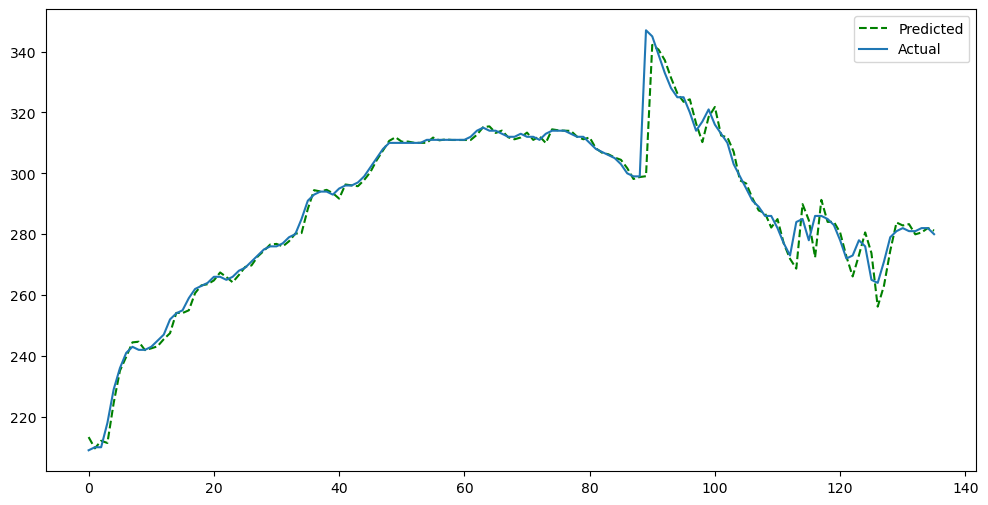

(136, 1)


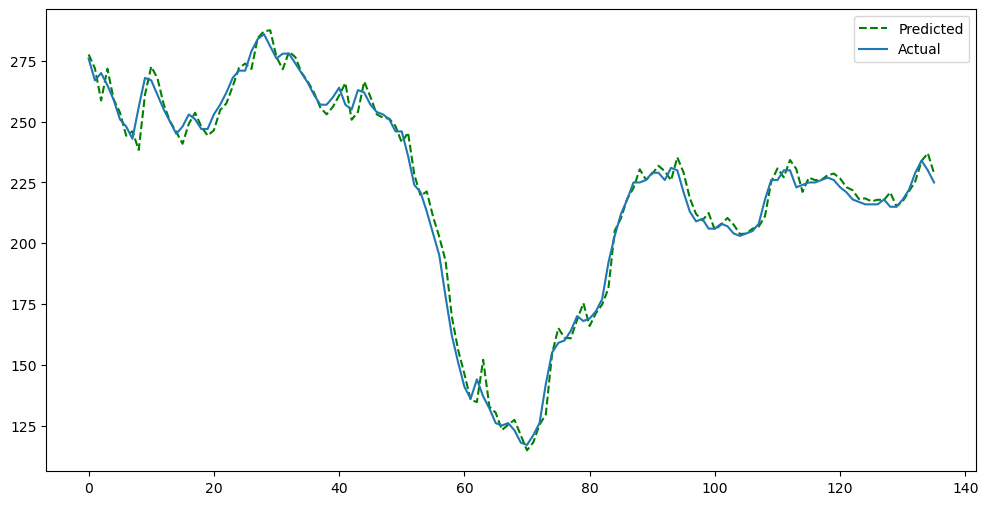

(136, 1)


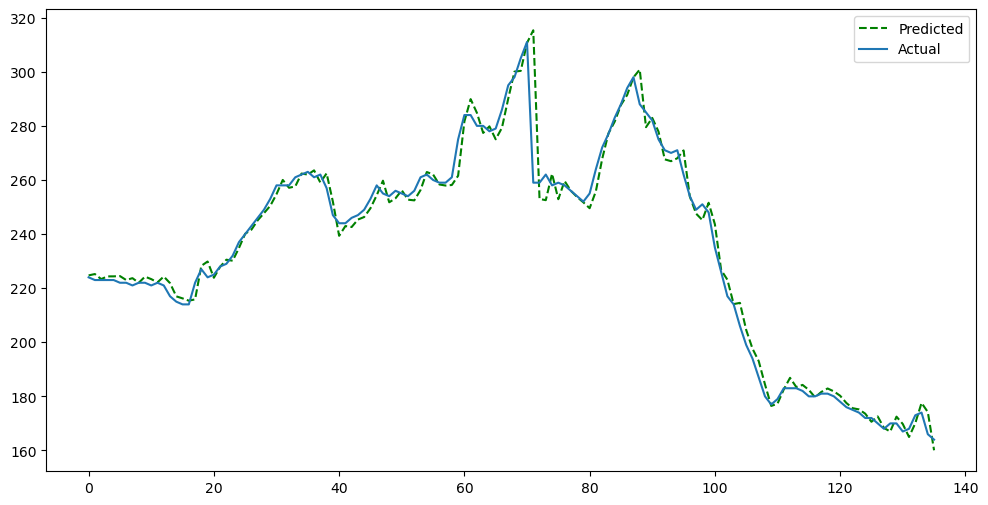

(136, 1)


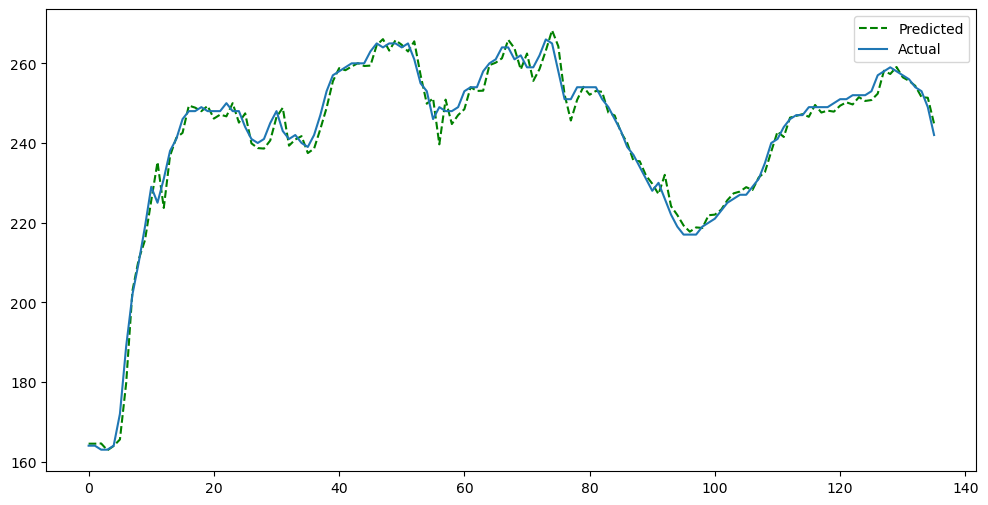

(136, 1)


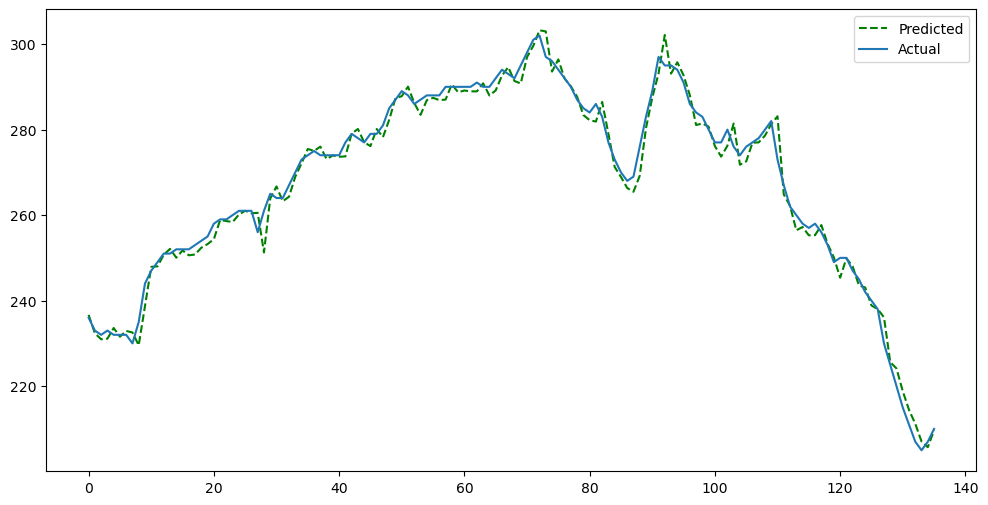

(136, 1)


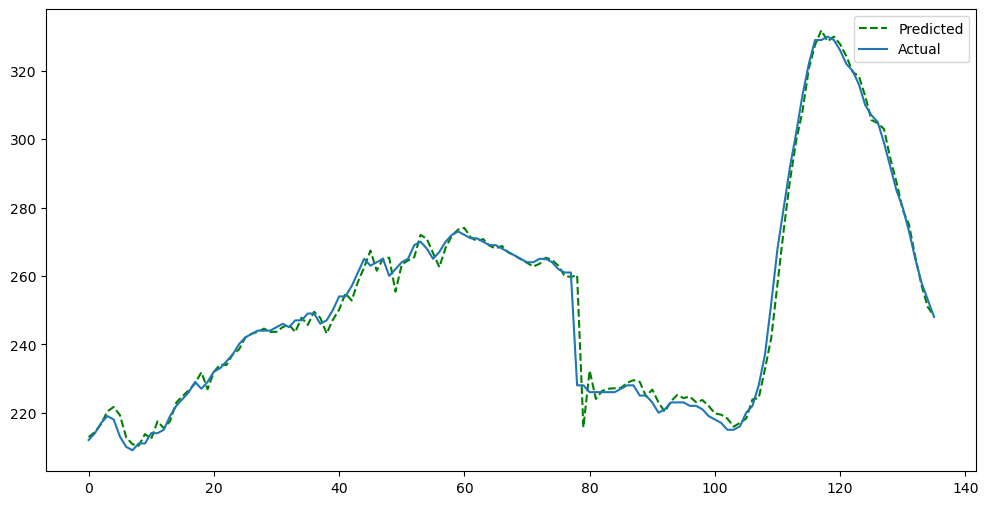

(136, 1)


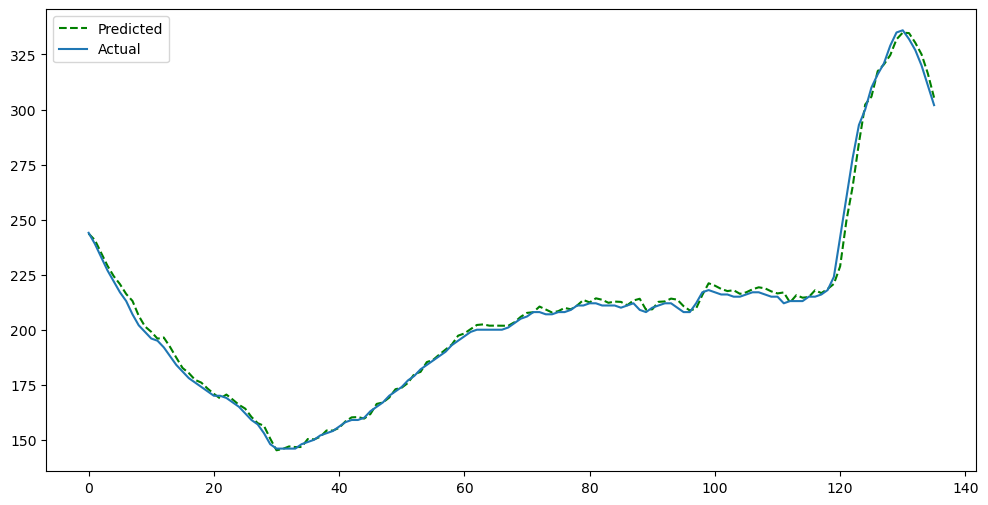

(136, 1)


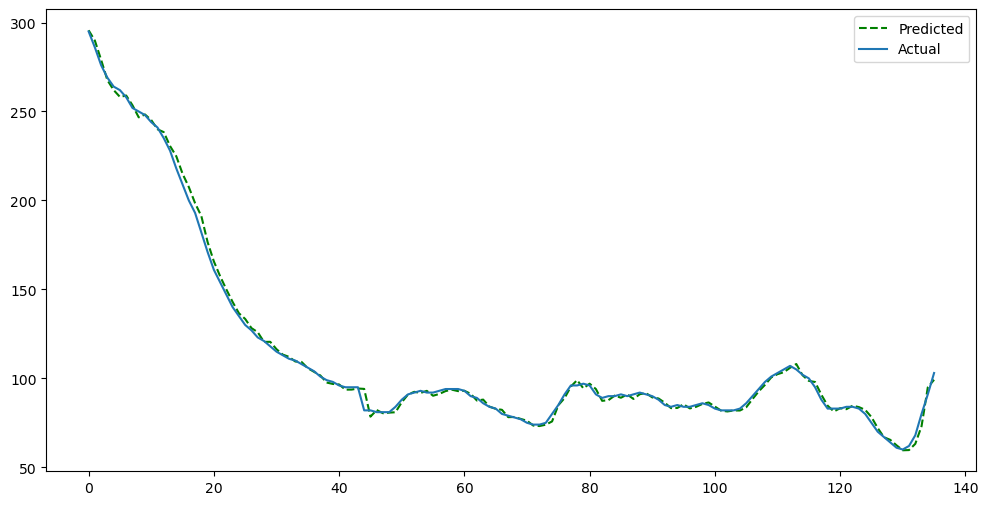

(136, 1)


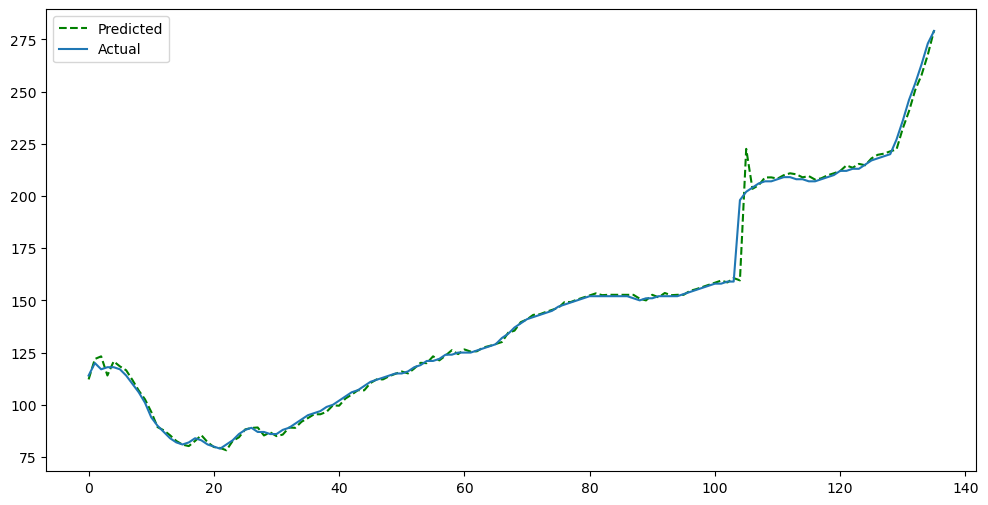

(136, 1)


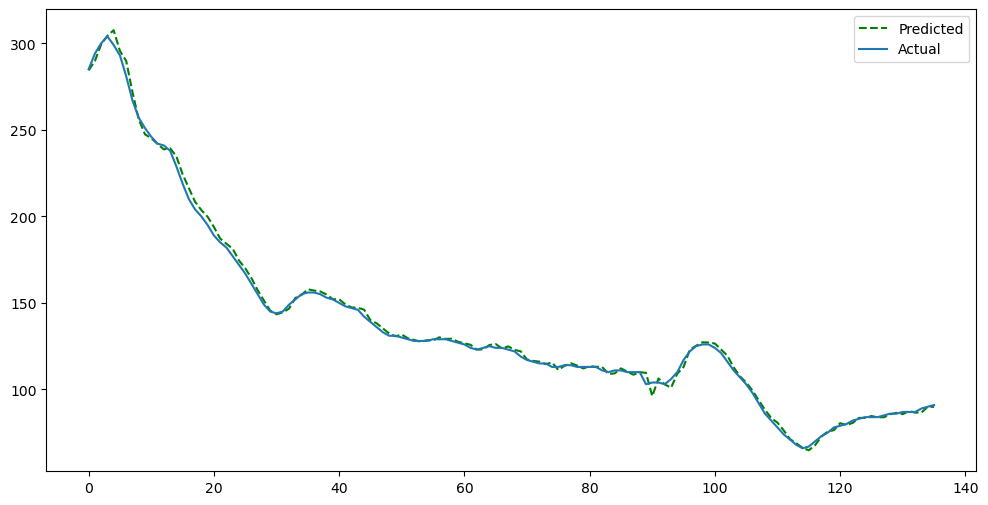

(136, 1)


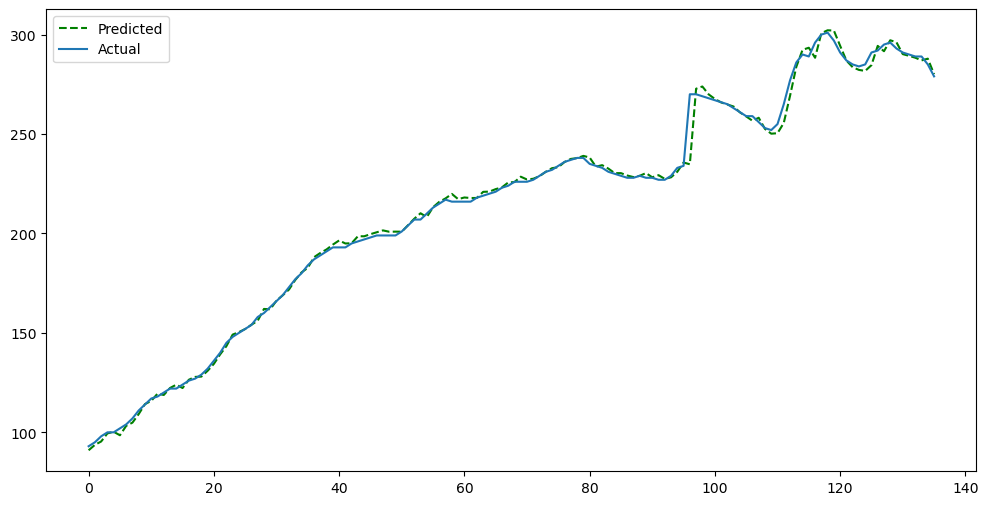

(136, 1)


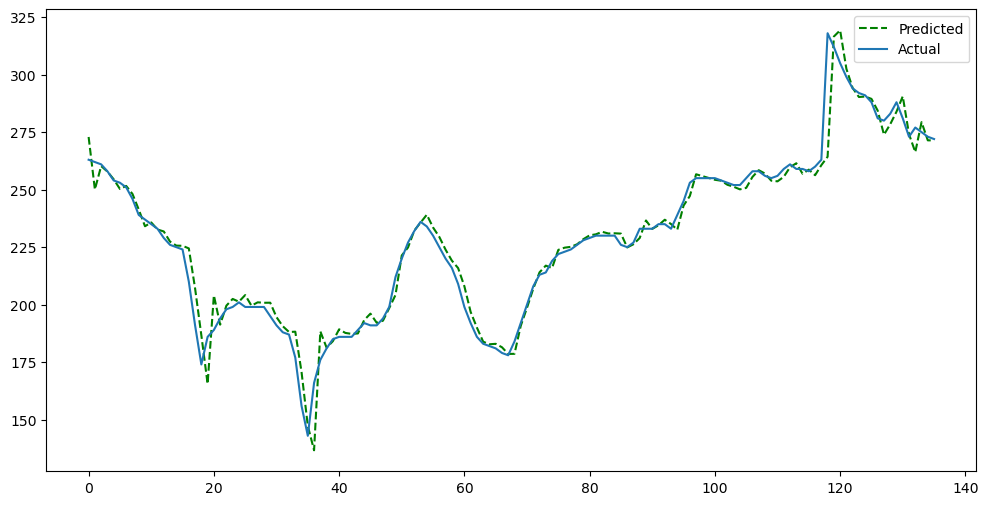

(136, 1)


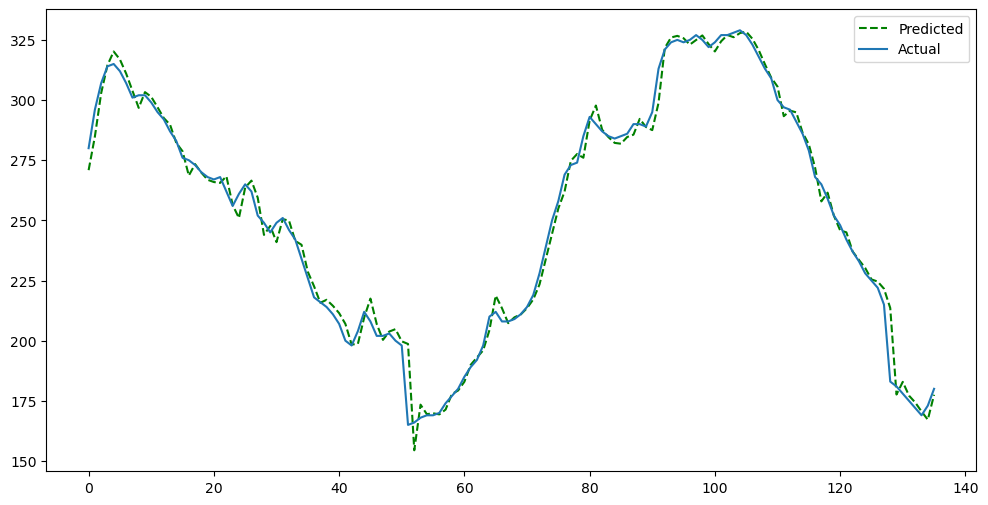

(136, 1)


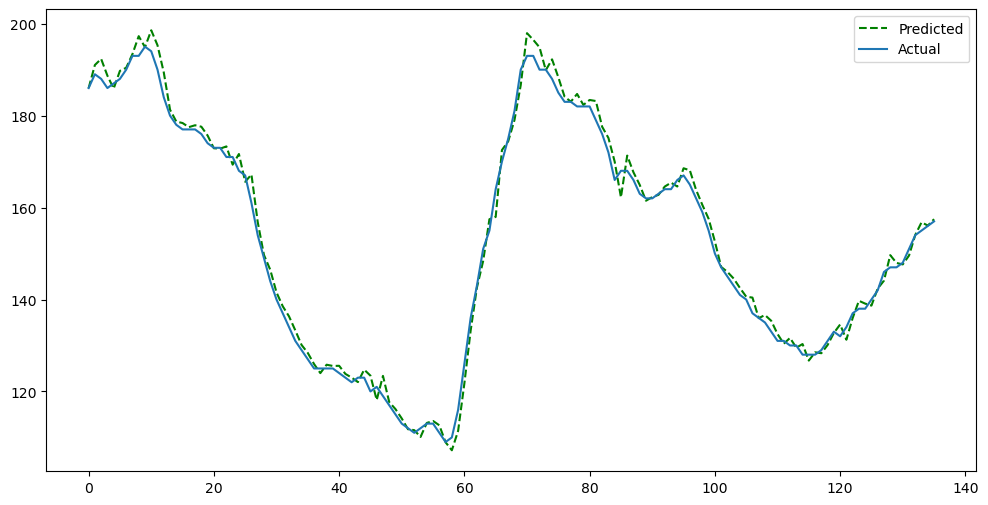

(136, 1)


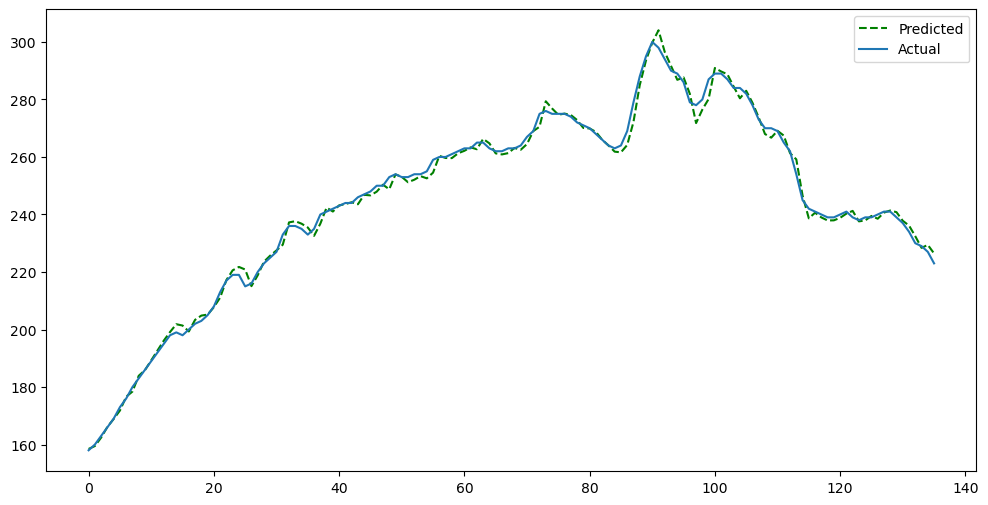

(155, 1)


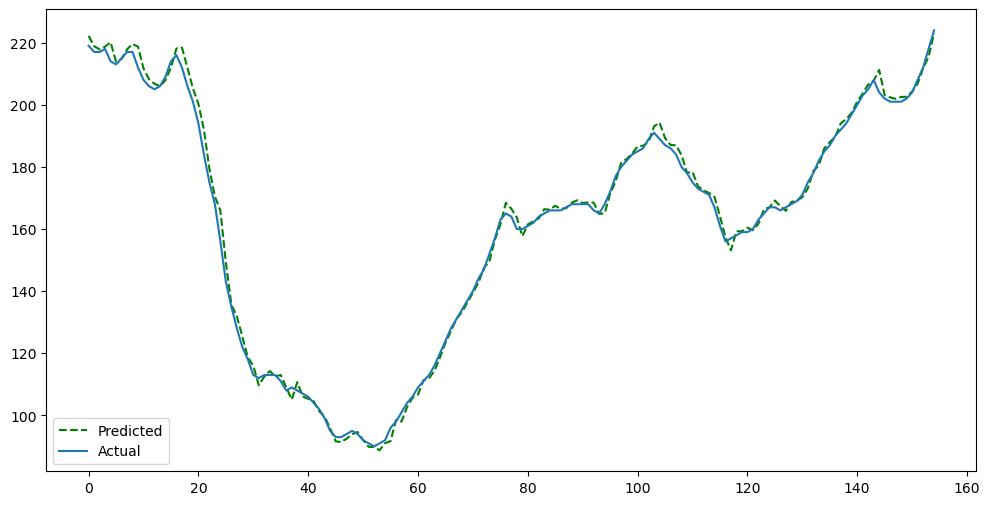

In [99]:
plot_model_predictions(lstm2, pred2, num_graphs=20)

In [60]:
fit_normalised_model(lstm, pred, scaler, lr=1e-3, MAX_EPOCHS=20)

Epoch 1/20
343/343 [==============================] - 6s 13ms/step - loss: 0.0053 - score_func: 21.1609
Epoch 2/20
343/343 [==============================] - 4s 13ms/step - loss: 0.0024 - score_func: 15.8909
Epoch 3/20
343/343 [==============================] - 5s 13ms/step - loss: 0.0019 - score_func: 13.9563
Epoch 4/20
343/343 [==============================] - 5s 13ms/step - loss: 0.0017 - score_func: 12.9877
Epoch 5/20
343/343 [==============================] - 4s 13ms/step - loss: 0.0015 - score_func: 12.3661
Epoch 6/20
343/343 [==============================] - 4s 13ms/step - loss: 0.0014 - score_func: 12.0377
Epoch 7/20
343/343 [==============================] - 5s 13ms/step - loss: 0.0013 - score_func: 11.6826
Epoch 8/20
343/343 [==============================] - 5s 13ms/step - loss: 0.0013 - score_func: 11.4322
Epoch 9/20
343/343 [==============================] - 5s 13ms/step - loss: 0.0012 - score_func: 11.2228
Epoch 10/20
343/343 [==============================] - 5s 13ms/s

In [61]:
lstm.evaluate(pred.test)

86/86 [==============================] - 1s 5ms/step - loss: 9.2846e-04 - score_func: 9.0708


[0.0009284632978960872, 9.070752143859863]

(136, 1)


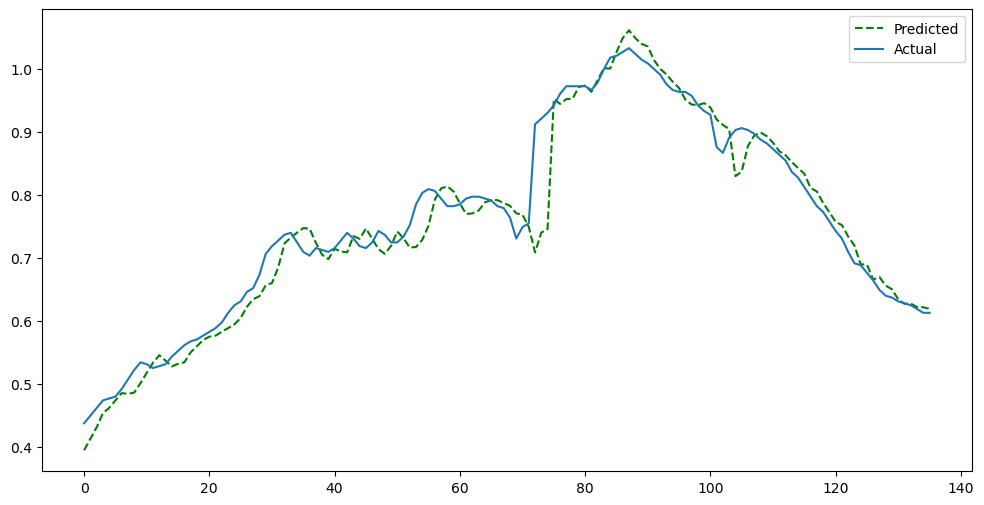

(136, 1)


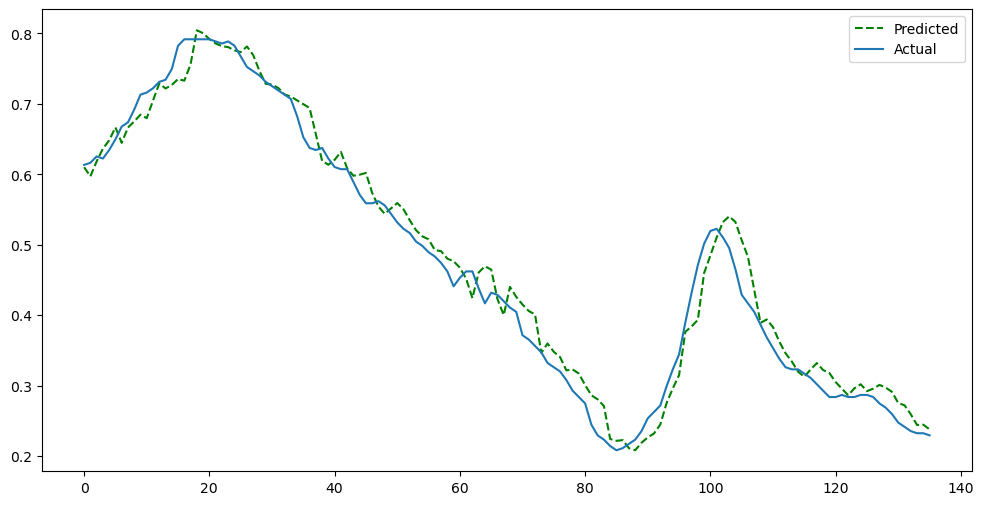

(136, 1)


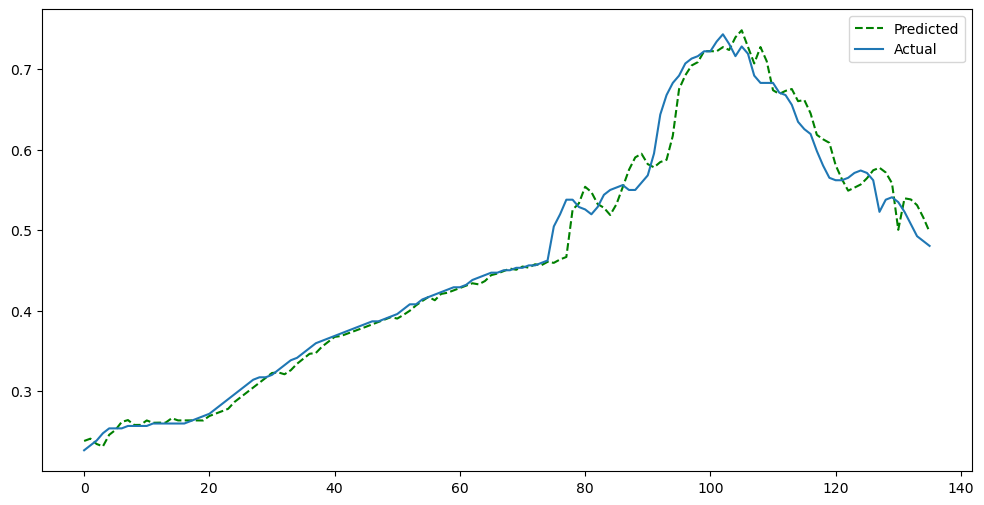

(136, 1)


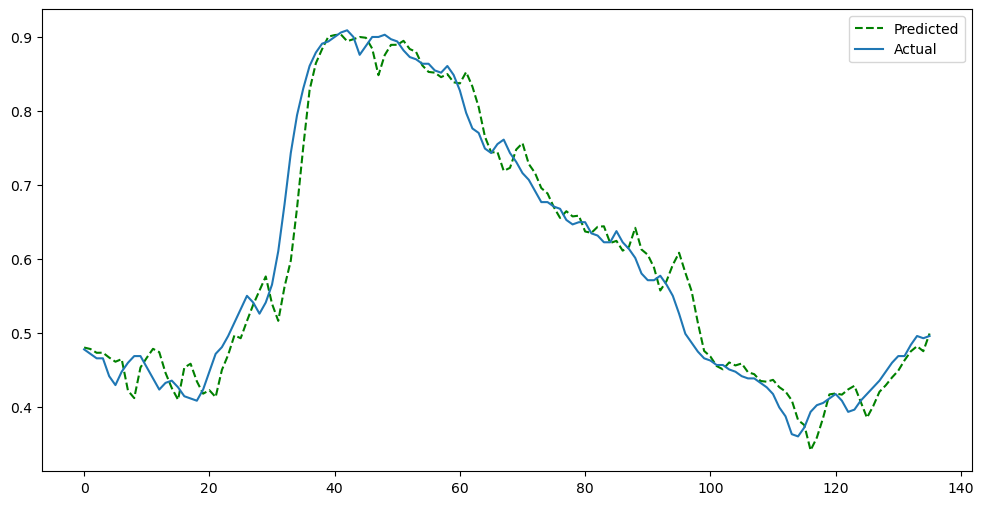

(136, 1)


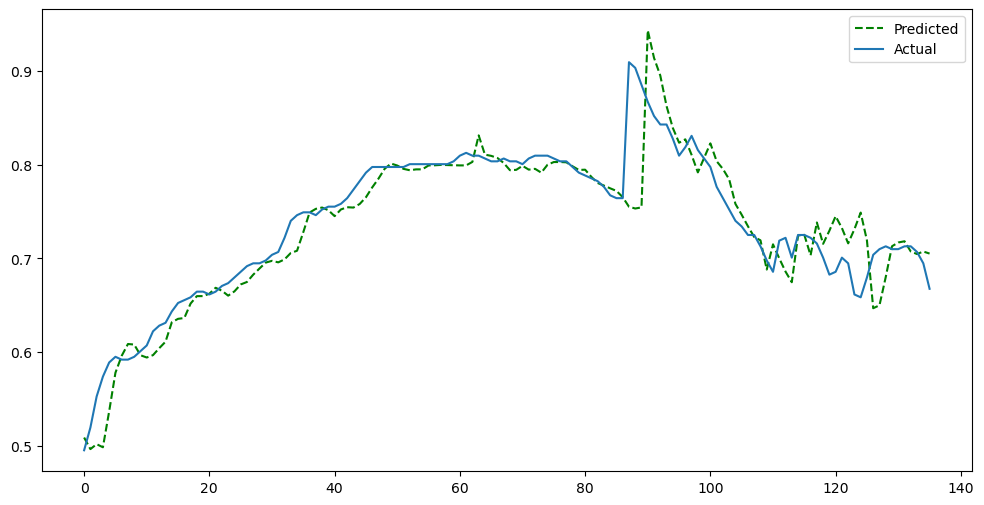

(136, 1)


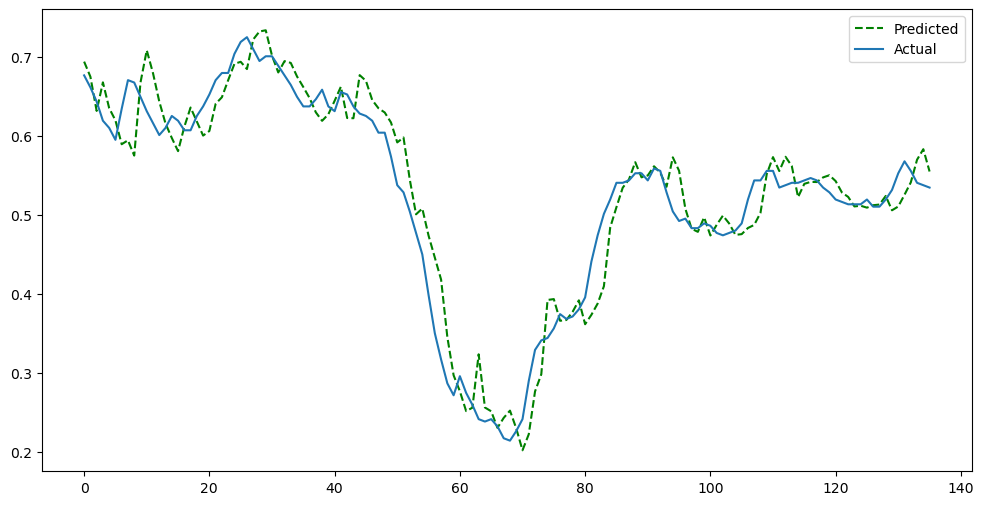

(136, 1)


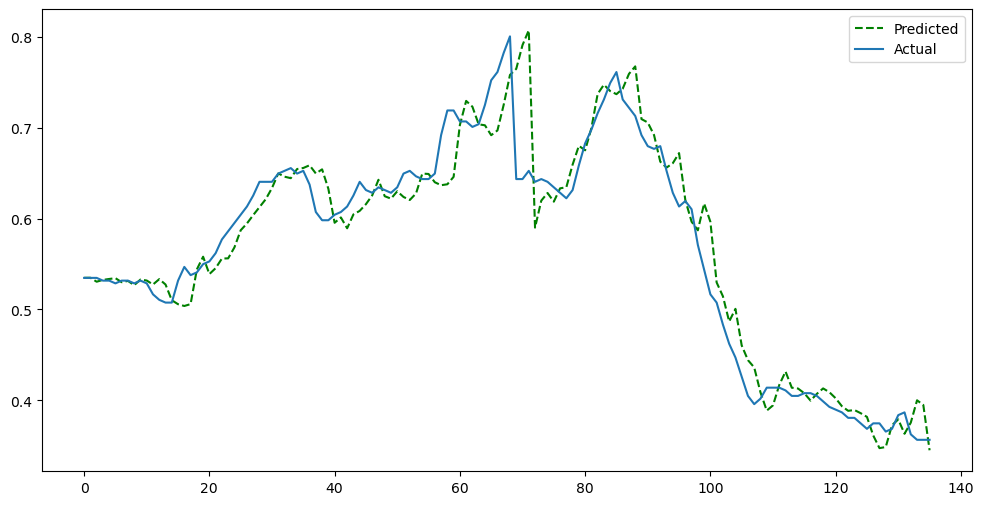

(136, 1)


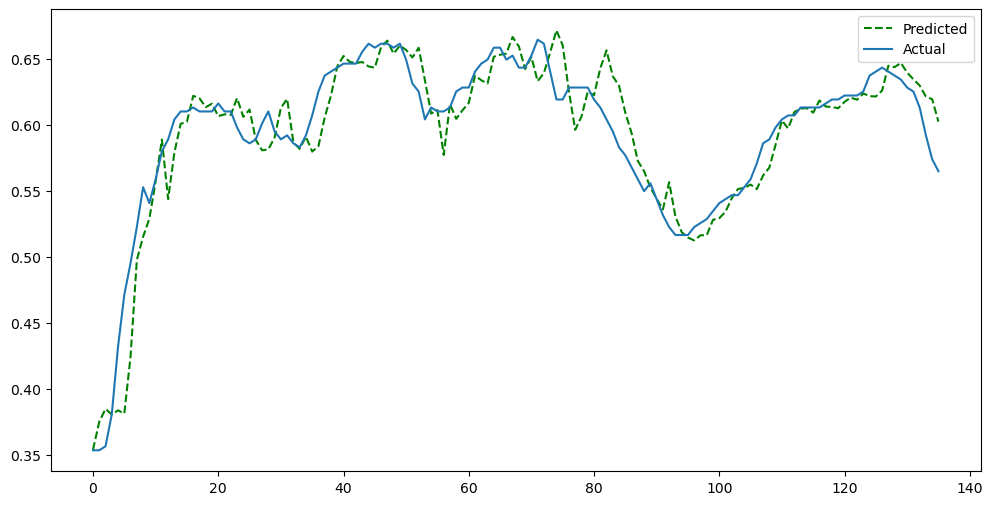

(136, 1)


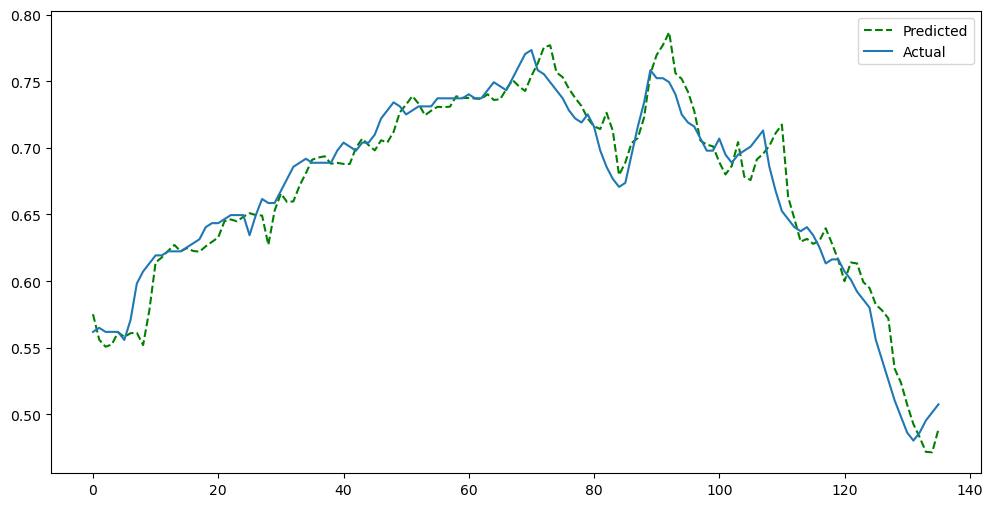

(136, 1)


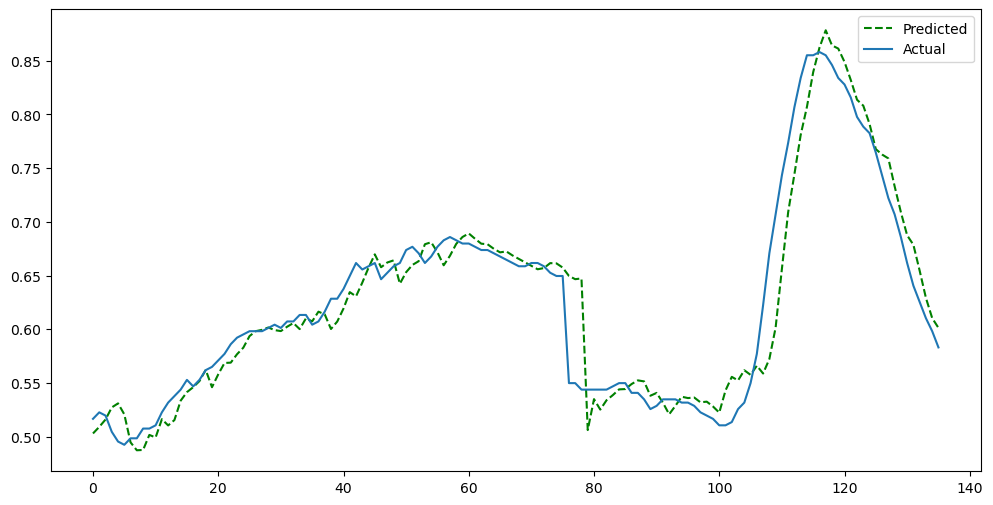

(136, 1)


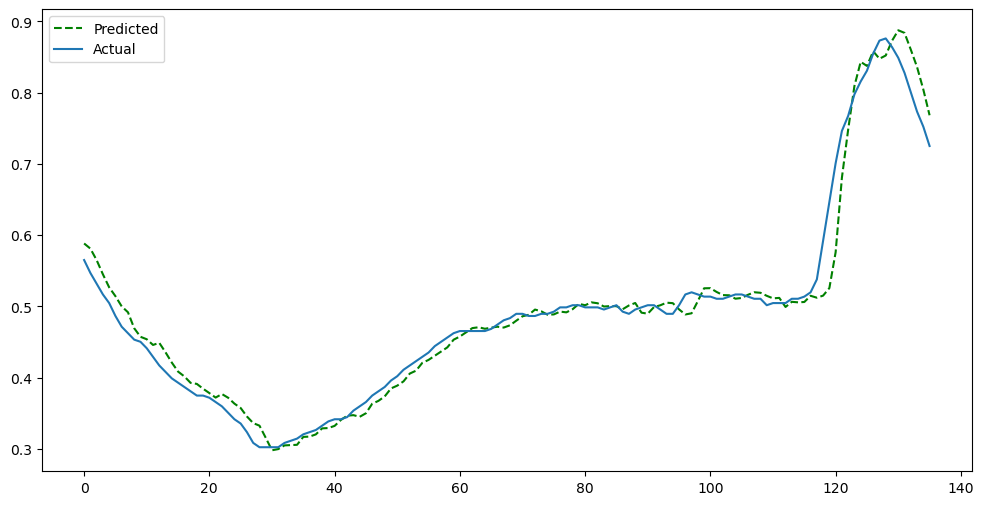

(136, 1)


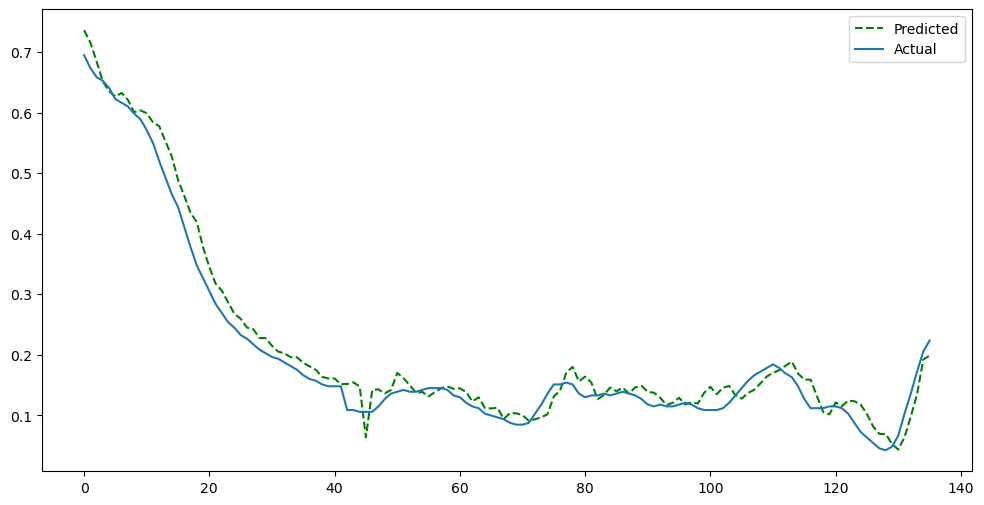

(136, 1)


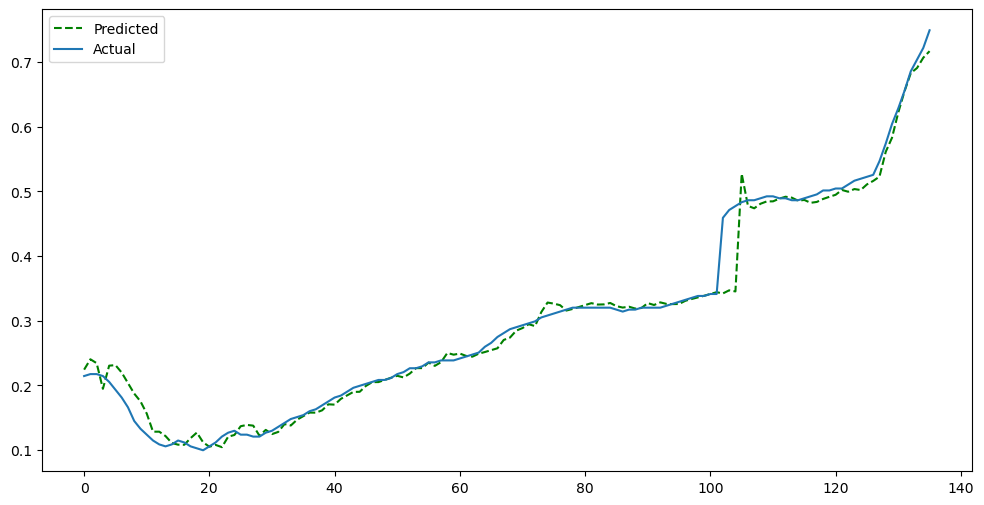

(136, 1)


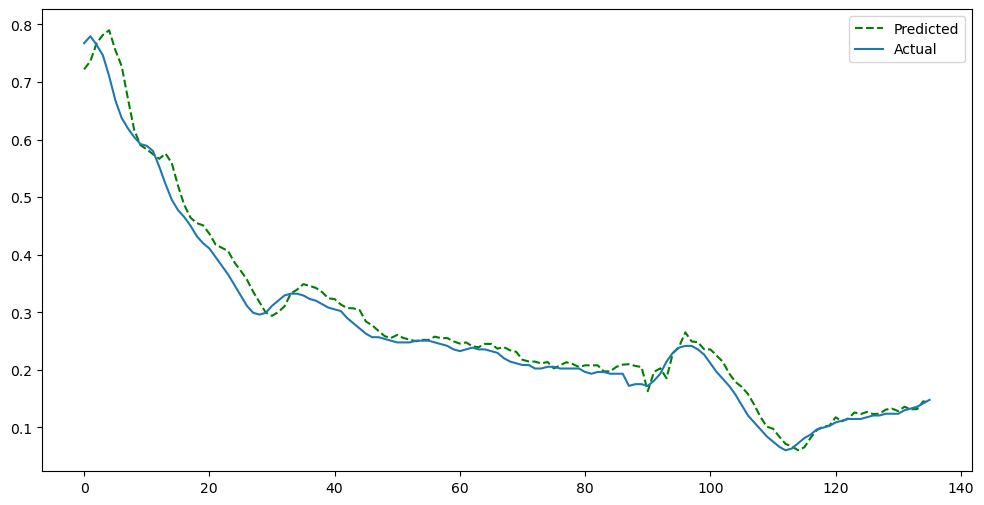

(136, 1)


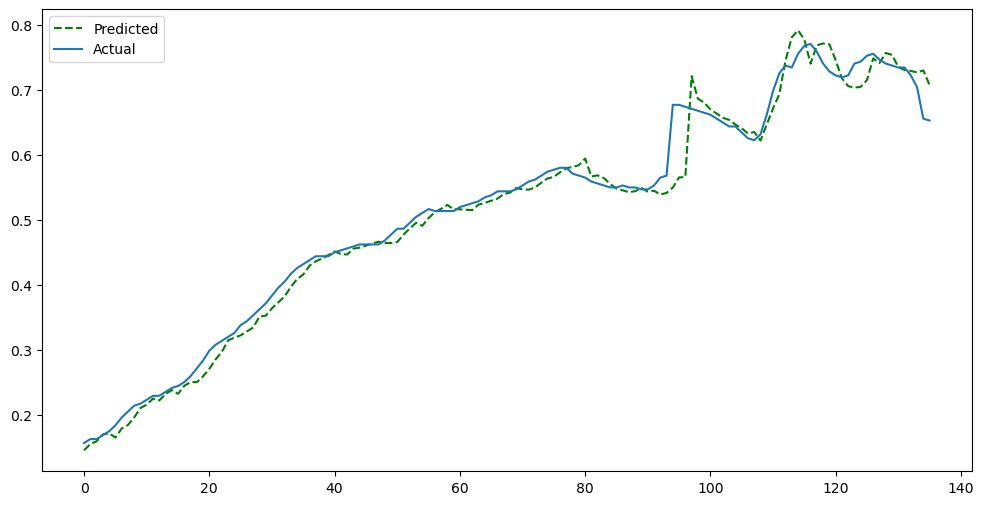

(136, 1)


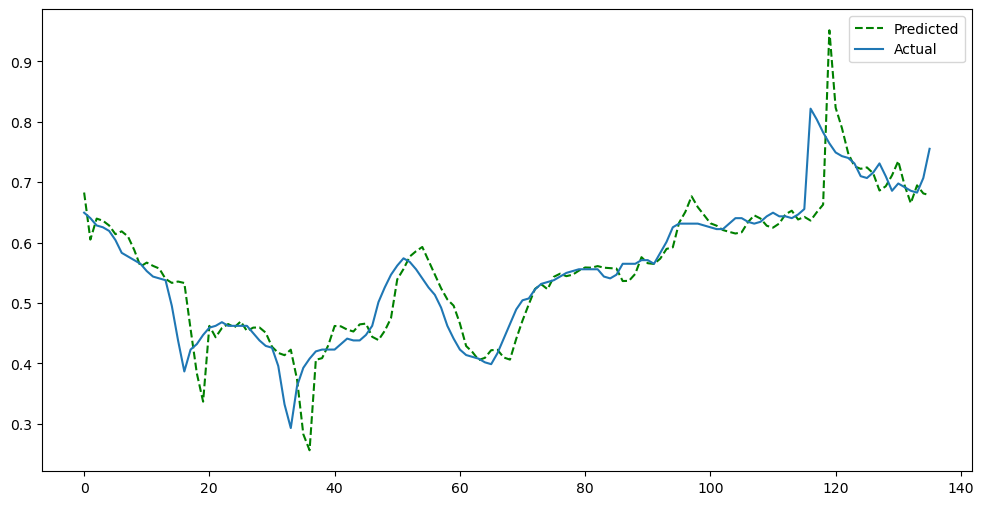

(136, 1)


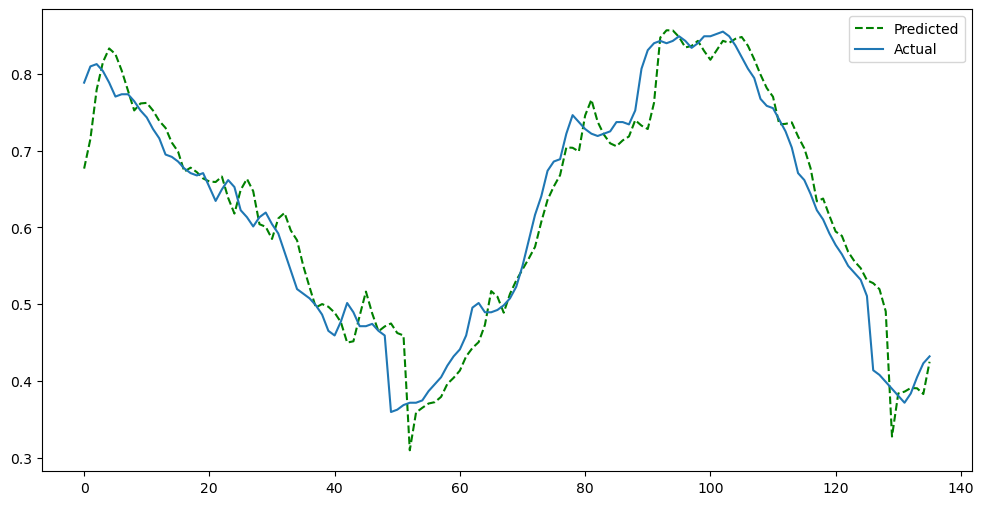

(136, 1)


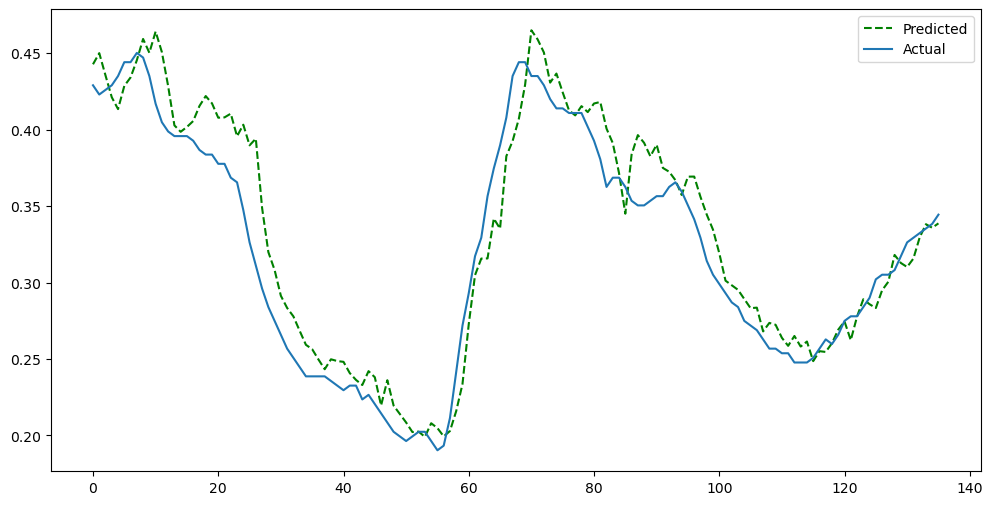

(136, 1)


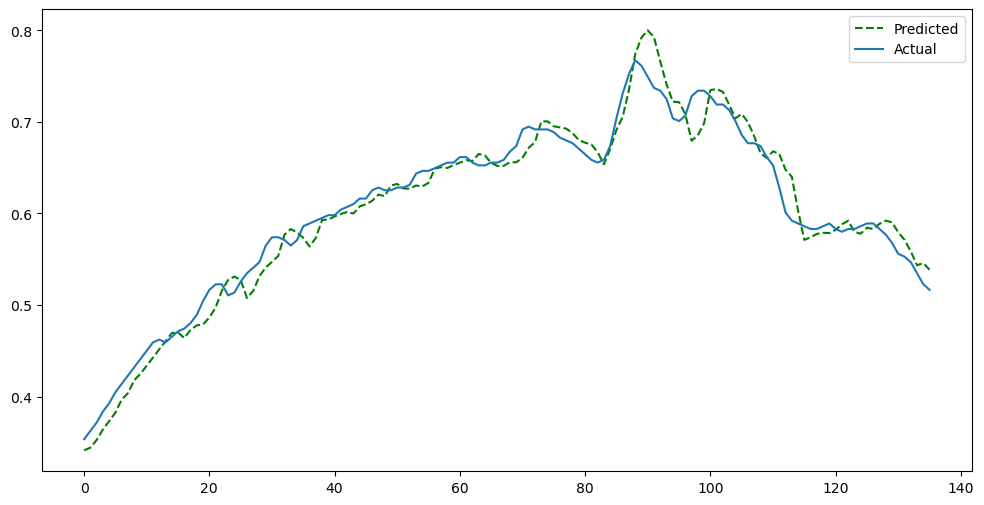

(153, 1)


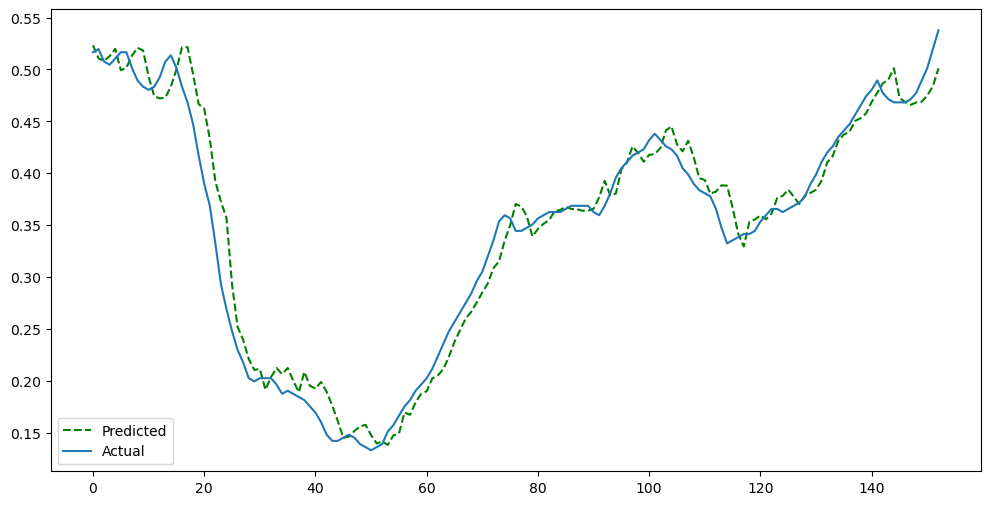

In [157]:
plot_model_predictions(lstm, pred, num_graphs=20)

In [134]:
lstm.evaluate(pred.test)

86/86 [==============================] - 1s 4ms/step - loss: 118.5266 - root_mean_squared_error: 10.8870 - mean_absolute_error: 7.1754


[118.52658081054688, 10.886991500854492, 7.17538595199585]

In [ ]:
#10.88

In [50]:
print(best_hps.get('lr'))
print(best_hps.get('lstm_units'))

0.001
352


In [53]:
model = tuner.hypermodel.build(best_hps)